In [1]:
# Import the libraries

import pandas as pd 
import numpy as np

from pprint import pprint

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

import spacy

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings("ignore")


/Users/siriamanda/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/siriamanda/opt/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


Code references:

https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/


In [2]:
df = pd.read_csv('/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/sentiment-analysis-of-reviews/01-sentiment-analysis/05-python-for-data/VADER-python-for-data.csv')


In [3]:
df.head()

,Unnamed: 0,date,review,rating,status,length,label,language_scores,language,scores,compound,sentiment
0,0,2021-03-11,"Interesting and clear, the difficulty in the e...",4,completer,186,pos,"{'language': 'en', 'score': 0.9999988844000527}",en,"{'neg': 0.146, 'neu': 0.505, 'pos': 0.35, 'com...",0.7957,pos
1,1,2021-03-11,"great, i have learned basics of python from th...",5,completer,56,pos,"{'language': 'en', 'score': 0.9999970049413354}",en,"{'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'comp...",0.6249,pos
2,2,2021-03-10,Recommended,5,completer,11,pos,"{'language': 'en', 'score': 0.8571409981818681}",en,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.2023,pos
3,3,2021-03-10,excellent,5,completer,9,pos,"{'language': 'ca', 'score': 0.8571389147750391}",ca,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.5719,pos
4,4,2021-03-10,Tamada sir is my biggest inspiration to comple...,5,completer,102,pos,"{'language': 'en', 'score': 0.9999982800455944}",en,"{'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'comp...",0.5267,pos


In [4]:
df.drop(['Unnamed: 0', 'language_scores', 'language', 'scores'], axis = 1, inplace = True)

In [5]:
df

,date,review,rating,status,length,label,compound,sentiment
0,2021-03-11,"Interesting and clear, the difficulty in the e...",4,completer,186,pos,0.7957,pos
1,2021-03-11,"great, i have learned basics of python from th...",5,completer,56,pos,0.6249,pos
2,2021-03-10,Recommended,5,completer,11,pos,0.2023,pos
3,2021-03-10,excellent,5,completer,9,pos,0.5719,pos
4,2021-03-10,Tamada sir is my biggest inspiration to comple...,5,completer,102,pos,0.5267,pos
...,...,...,...,...,...,...,...,...
3111,2018-08-08,Good overall if you already have a grasp of py...,3,dropout,135,neu,0.1027,pos
3112,2018-08-06,good introductory course,5,dropout,24,pos,0.4404,pos
3113,2018-08-03,robotic teaching,2,dropout,16,neg,0.0000,neu
3114,2018-08-03,I recommend!,5,dropout,12,pos,0.4199,pos


In [6]:
# Check for null values

len(df[df['review'].isna()==True])

0

In [7]:
# Drop null values

# df.dropna(inplace = True)

In [8]:
# Check for null values

# len(df[df['review'].isna()==True])

In [9]:
# Reset the index

# df = df.reset_index(drop = True)

In [10]:
# df

In [11]:
# Define a function to plot the most frequent words

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 45)
    plt.show()

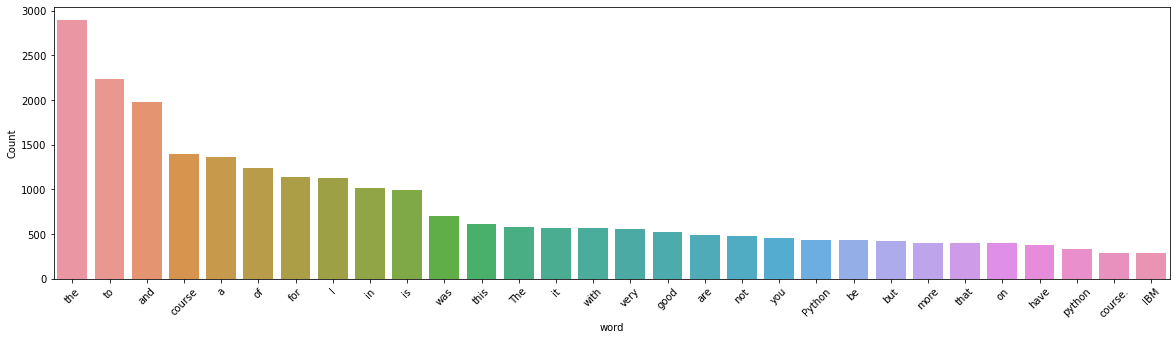

In [12]:
# The most frquent words are stop words such as 'to' and 'the' we will remove these in the preprocessing steps

freq_words(df['review'])

## Preprocessing

In [13]:
# Covert to lowercase

df['preprocessed'] =  df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['preprocessed'].head()

0    interesting and clear, the difficulty in the e...
1    great, i have learned basics of python from th...
2                                          recommended
3                                            excellent
4    tamada sir is my biggest inspiration to comple...
Name: preprocessed, dtype: object

In [14]:
# Remove punctuations

df['preprocessed'] = df['preprocessed'].str.replace('[^\w\s]','')
df['preprocessed'].head()

0    interesting and clear the difficulty in the ex...
1    great i have learned basics of python from thi...
2                                          recommended
3                                            excellent
4    tamada sir is my biggest inspiration to comple...
Name: preprocessed, dtype: object

In [15]:
# Remove stopwords

stop = stopwords.words('english')
stop.extend(['good', 'great', 'really', 'like', 'nice'])

df['preprocessed'] = df['preprocessed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['preprocessed'].head()

0    interesting clear difficulty exercises escalat...
1                         learned basics python course
2                                          recommended
3                                            excellent
4    tamada sir biggest inspiration complete course...
Name: preprocessed, dtype: object

In [16]:
# Remove short words (length < 3)

# df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# df['review'].head()

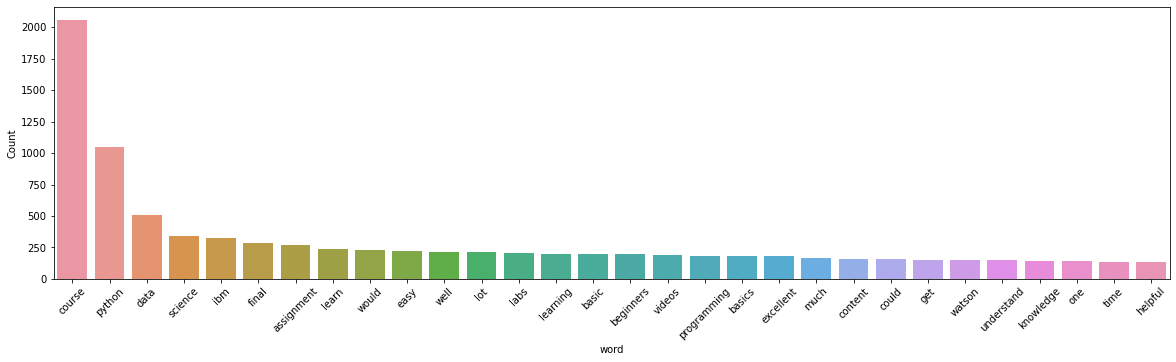

In [17]:
# Look at the most frequent words again 

freq_words(df['preprocessed'])

In [18]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')

df['preprocessed'] = df['preprocessed'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['preprocessed'].head(5)


0    [interesting, clear, difficulty, exercises, es...
1                    [learned, basics, python, course]
2                                        [recommended]
3                                          [excellent]
4    [tamada, sir, biggest, inspiration, complete, ...
Name: preprocessed, dtype: object

In [19]:
# Add speech tags

df['preprocessed'] = df['preprocessed'].apply(nltk.tag.pos_tag)
df['preprocessed'].head()

0    [(interesting, VBG), (clear, JJ), (difficulty,...
1    [(learned, VBN), (basics, NNS), (python, VBP),...
2                                 [(recommended, VBN)]
3                                    [(excellent, NN)]
4    [(tamada, NN), (sir, NN), (biggest, JJS), (ins...
Name: preprocessed, dtype: object

In [20]:
# Define function to convert parts of speech tags to wordnet’s format

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [21]:
# Apply the function to the tagged data

df['preprocessed'] = df['preprocessed'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df['preprocessed'].head()

0    [(interesting, v), (clear, a), (difficulty, n)...
1    [(learned, v), (basics, n), (python, v), (cour...
2                                   [(recommended, v)]
3                                     [(excellent, n)]
4    [(tamada, n), (sir, n), (biggest, a), (inspira...
Name: preprocessed, dtype: object

In [22]:
# Create lemmatizer

lemmatizer = WordNetLemmatizer()

# Apply to data 

df['preprocessed'] = df['preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])
df['preprocessed'].head()

0    [interest, clear, difficulty, exercise, escala...
1                       [learn, basic, python, course]
2                                          [recommend]
3                                          [excellent]
4    [tamada, sir, big, inspiration, complete, cour...
Name: preprocessed, dtype: object

In [23]:
# Join reviews

df['joined'] = df['preprocessed'].apply(lambda x: ' '.join(x))

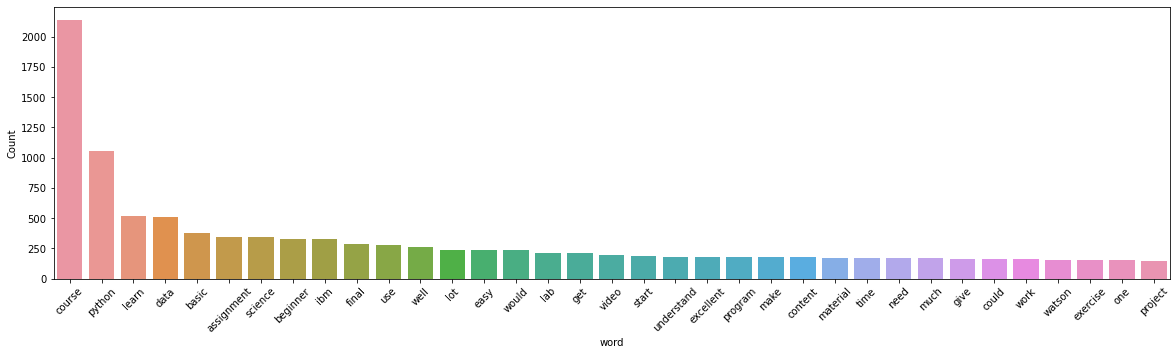

In [24]:
# Most frequent words after lemmatizing 

freq_words(df['joined'], 35)

## LDA Topic Modeling

In [25]:
# Create a dictionary from 'df_sen['review']' containing the number of times a word appears in the training set

dictionary = gensim.corpora.Dictionary(df['preprocessed'])

In [26]:
# Gensim filter extremes

# Filter out tokens that appear in:
# Less than 50 documents, more than 0.5 documents, and keep only 100000 most frquent tokens

# dictionary.filter_extremes(no_below = 50, no_above = 0.5, keep_n = 100000)

In [27]:
# Gensim doc2bow
# Create a dictionary reporting how many words and how many times those words appear

corpus = [dictionary.doc2bow(doc) for doc in df['preprocessed']]


In [28]:
# Add TF-IDF

tfidf = models.TfidfModel(corpus)      # Create a TF-IDF model
corpus_tfidf = tfidf[corpus]  

In [29]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaMulticore

# Build LDA model
lda_model = LDA(corpus = corpus, id2word = dictionary, num_topics = 5, random_state = 100,
                chunksize = 100, passes = 10)

In [30]:
# Explore the words occurring in each topic and its relative weight

for id, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(id, topic))

Topic: 0
Word: 0.096*"course" + 0.082*"python" + 0.040*"data" + 0.032*"basic" + 0.029*"science" + 0.022*"beginner" + 0.021*"learn" + 0.013*"start" + 0.011*"well" + 0.011*"introduction"

Topic: 1
Word: 0.057*"course" + 0.026*"content" + 0.020*"assignment" + 0.013*"material" + 0.013*"bit" + 0.011*"need" + 0.011*"final" + 0.011*"thank" + 0.010*"lab" + 0.010*"clear"

Topic: 2
Word: 0.046*"course" + 0.035*"excellent" + 0.031*"learn" + 0.030*"easy" + 0.019*"awesome" + 0.016*"understand" + 0.013*"lot" + 0.010*"thing" + 0.010*"ibm" + 0.009*"thanks"

Topic: 3
Word: 0.037*"course" + 0.023*"final" + 0.020*"assignment" + 0.012*"project" + 0.012*"ibm" + 0.012*"use" + 0.011*"would" + 0.010*"time" + 0.009*"lot" + 0.009*"python"

Topic: 4
Word: 0.030*"course" + 0.015*"assignment" + 0.014*"week" + 0.010*"watson" + 0.010*"would" + 0.010*"ibm" + 0.009*"question" + 0.009*"complete" + 0.009*"helpful" + 0.009*"lab"



### Visualise with pyLDAvis

Original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.075540 -0.046638       1        1  31.345166
0      0.186234 -0.098805       2        1  30.968159
4     -0.135910 -0.001505       3        1  16.446991
1     -0.052281 -0.025315       4        1  11.857357
2      0.077497  0.172263       5        1   9.382328, topic_info=           Term        Freq       Total Category  logprob  loglift
15       python  997.000000  997.000000  Default  30.0000  30.0000
99         data  434.000000  434.000000  Default  29.0000  29.0000
107     science  301.000000  301.000000  Default  28.0000  28.0000
13        basic  353.000000  353.000000  Default  27.0000  27.0000
17    excellent  154.000000  154.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
164     concept   16.980826  115.994908   Topic5  -5.2333   0.4449
274  experience   16.616353  116.799019   Topic5  -5.2550   0.4163
318       could   15.026170  146.322222   Topic5  -5.3556   0.0903
2         clear   14.399382  106.442700   Topic5  -5.3982   0.3659
12         well   14.547421  223.630039   Topic5  -5.3879  -0.3662

[376 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1529      1  0.209825      1
1529      2  0.083930      1
1529      3  0.713404      1
1547      3  0.808170     10
1455      1  0.267293      2
...     ...       ...    ...
96        3  0.232998  would
96        4  0.046600  would
96        5  0.055072  would
97        1  0.735816  write
97        3  0.253730  write

[706 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 2, 3])

What is topic perplexity and topic coherence: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [32]:
# Calculate Perplexity and Coherence

# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model = lda_model, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.831443532904345

Coherence Score:  0.557005666998422


## Hyperparameter Tuning

Code references

Find the optimal number of topics, alpha and beta: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

What is alpha and beta: https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/

## Calculate the coherence score

Code reference: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [33]:
# Determine the optiomal number of topics by calculating the coherence score

# Define function for calculating coherence score

def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus = corpus, num_topics = num_topics, id2word = dictionary, random_state = 100,
                chunksize = 100, passes = 10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary = dictionary, corpus = corpus, texts = df['preprocessed'], start = 2, limit = 10, step = 1)

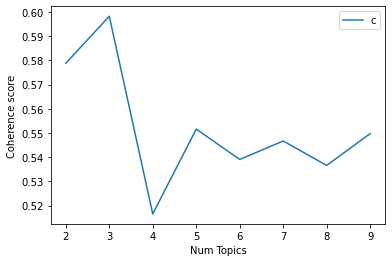

In [35]:
# Show graph

limit = 10; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()


In [36]:
# Print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5788
Num Topics = 3  has Coherence Value of 0.5983
Num Topics = 4  has Coherence Value of 0.5166
Num Topics = 5  has Coherence Value of 0.5516
Num Topics = 6  has Coherence Value of 0.5391
Num Topics = 7  has Coherence Value of 0.5467
Num Topics = 8  has Coherence Value of 0.5366
Num Topics = 9  has Coherence Value of 0.5497


## LDA Mallet Model

Code reference:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [ ]:
mallet_path = '/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 5, id2word = dictionary)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted = False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model = ldamallet, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# The coherence score using the Mallet Model is lower than the original LDA Model